<a href="https://colab.research.google.com/github/durml91/MMath-Project/blob/duo-branch/Image_Diffusion_(working)/Copy_of_CIFAR_10_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install einops
!pip install diffrax
!pip install optax
!pip install equinox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 1.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.1/138.1 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.3/88.3 KB 3.3 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 2.7.1
    Uninstalling typeguard-2.7.1:
      Successfully uninstalled typeguard-2.7.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.9/154.9 KB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 KB 12.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import array
import functools as ft
import gzip
import os
import struct
import urllib.request

import diffrax as dfx  # https://github.com/patrick-kidger/diffrax
import einops  # https://github.com/arogozhnikov/einops
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import optax  # https://github.com/deepmind/optax

import equinox as eqx

In [3]:
import shutil

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
def cifar():
  from tensorflow.keras.datasets import cifar10
  (x_train, y_train), (x_test, y_test) = cifar10.load_data()

  set1 = jnp.array(x_train)
  set2 = jnp.array(x_test)

  data = jnp.concatenate((set1, set2))

  data_reag = einops.rearrange(data, "n h w c -> n c h w")
  return data_reag

In [6]:
class MixerBlock(eqx.Module):
    patch_mixer: eqx.nn.MLP
    hidden_mixer: eqx.nn.MLP
    norm1: eqx.nn.LayerNorm
    norm2: eqx.nn.LayerNorm

    def __init__(
        self, num_patches, hidden_size, mix_patch_size, mix_hidden_size, *, key
    ):
        tkey, ckey = jr.split(key, 2)
        self.patch_mixer = eqx.nn.MLP(
            num_patches, num_patches, mix_patch_size, depth=1, key=tkey
        )
        self.hidden_mixer = eqx.nn.MLP(
            hidden_size, hidden_size, mix_hidden_size, depth=1, key=ckey
        )
        self.norm1 = eqx.nn.LayerNorm((hidden_size, num_patches))
        self.norm2 = eqx.nn.LayerNorm((num_patches, hidden_size))

    def __call__(self, y):
        y = y + jax.vmap(self.patch_mixer)(self.norm1(y))
        y = einops.rearrange(y, "c p -> p c")
        y = y + jax.vmap(self.hidden_mixer)(self.norm2(y))
        y = einops.rearrange(y, "p c -> c p")
        return y


class Mixer2d(eqx.Module):
    conv_in: eqx.nn.Conv2d
    conv_out: eqx.nn.ConvTranspose2d
    blocks: list
    norm: eqx.nn.LayerNorm
    t1: float

    def __init__(
        self,
        img_size,
        patch_size,
        hidden_size,
        mix_patch_size,
        mix_hidden_size,
        num_blocks,
        t1,
        *,
        key,
    ):
        input_size, height, width = img_size
        assert (height % patch_size) == 0
        assert (width % patch_size) == 0
        num_patches = (height // patch_size) * (width // patch_size)
        inkey, outkey, *bkeys = jr.split(key, 2 + num_blocks)

        self.conv_in = eqx.nn.Conv2d(
            input_size + 1, hidden_size, patch_size, stride=patch_size, key=inkey
        )
        self.conv_out = eqx.nn.ConvTranspose2d(
            hidden_size, input_size, patch_size, stride=patch_size, key=outkey
        )
        self.blocks = [
            MixerBlock(
                num_patches, hidden_size, mix_patch_size, mix_hidden_size, key=bkey
            )
            for bkey in bkeys
        ]
        self.norm = eqx.nn.LayerNorm((hidden_size, num_patches))
        self.t1 = t1

    def __call__(self, t, y):
        t = t / self.t1
        _, height, width = y.shape
        t = einops.repeat(t, "-> 1 h w", h=height, w=width)
        y = jnp.concatenate([y, t])
        y = self.conv_in(y)
        _, patch_height, patch_width = y.shape
        y = einops.rearrange(y, "c h w -> c (h w)")
        for block in self.blocks:
            y = block(y)
        y = self.norm(y)
        y = einops.rearrange(y, "c (h w) -> c h w", h=patch_height, w=patch_width)
        return self.conv_out(y)

In [7]:
def single_loss_fn(model, weight, int_beta, data, t, key):
    mean = data * jnp.exp(-0.5 * int_beta(t))
    var = jnp.maximum(1 - jnp.exp(-int_beta(t)), 1e-5)
    std = jnp.sqrt(var)
    noise = jr.normal(key, data.shape)
    y = mean + std * noise
    pred = model(t, y)
    return weight(t) * jnp.mean((pred + noise / std) ** 2)


def batch_loss_fn(model, weight, int_beta, data, t1, key):
    batch_size = data.shape[0]
    tkey, losskey = jr.split(key)
    losskey = jr.split(losskey, batch_size)
    # Low-discrepancy sampling over t to reduce variance
    t = jr.uniform(tkey, (batch_size,), minval=0, maxval=t1 / batch_size)
    t = t + (t1 / batch_size) * jnp.arange(batch_size)
    loss_fn = ft.partial(single_loss_fn, model, weight, int_beta)
    loss_fn = jax.vmap(loss_fn)
    return jnp.mean(loss_fn(data, t, losskey))


@eqx.filter_jit
def single_sample_fn(model, int_beta, data_shape, dt0, t1, key):
    def drift(t, y, args):
        _, beta = jax.jvp(int_beta, (t,), (jnp.ones_like(t),))
        return -0.5 * beta * (y + model(t, y))

    term = dfx.ODETerm(drift)
    solver = dfx.Tsit5()
    t0 = 0
    y1 = jr.normal(key, data_shape)
    # reverse time, solve from t1 to t0
    sol = dfx.diffeqsolve(term, solver, t1, t0, -dt0, y1, adjoint=dfx.NoAdjoint())
    return sol.ys[0]

In [8]:
def dataloader(data, batch_size, *, key):
    dataset_size = data.shape[0]
    indices = jnp.arange(dataset_size)
    while True:
        perm = jr.permutation(key, indices)
        (key,) = jr.split(key, 1)
        start = 0
        end = batch_size
        while end < dataset_size:
            batch_perm = perm[start:end]
            yield data[batch_perm]
            start = end
            end = start + batch_size

In [9]:
@eqx.filter_jit
def make_step(model, weight, int_beta, data, t1, key, opt_state, opt_update):
    loss_fn = eqx.filter_value_and_grad(batch_loss_fn)
    loss, grads = loss_fn(model, weight, int_beta, data, t1, key)
    updates, opt_state = opt_update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    key = jr.split(key, 1)[0]
    return loss, model, key, opt_state

In [ ]:
def main(
    # Model hyperparameters
    patch_size=4,
    hidden_size=64,
    mix_patch_size=512,
    mix_hidden_size=512,
    num_blocks=4,
    t1=10.0,
    # Optimisation hyperparameters
    num_steps=1_000_000,
    lr=3e-4,
    batch_size=256,
    print_every=10_000,
    # Sampling hyperparameters
    dt0=0.1,
    #sample_size=4,
    # Seed
    seed=2023,
):
    key = jr.PRNGKey(seed)
    model_key, train_key, loader_key, sample_key = jr.split(key, 4)
    data = cifar()
    data_mean = jnp.mean(data)
    data_std = jnp.std(data)
    data_max = jnp.max(data)
    data_min = jnp.min(data)
    data_shape = data.shape[1:]
    data = (data - data_mean) / data_std

    model = Mixer2d(
        data_shape,
        patch_size,
        hidden_size,
        mix_patch_size,
        mix_hidden_size,
        num_blocks,
        t1,
        key=model_key,
    )
    int_beta = lambda t: t  # Try experimenting with other options here!
    weight = lambda t: 1 - jnp.exp(
        -int_beta(t)
    )  # Just chosen to upweight the region near t=0.

    opt = optax.adabelief(lr)
    # Optax will update the floating-point JAX arrays in the model.
    opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))

    total_value = 0
    total_size = 0
    for step, data in zip(
        range(num_steps), dataloader(data, batch_size, key=loader_key)
    ):
        value, model, train_key, opt_state = make_step(
            model, weight, int_beta, data, t1, train_key, opt_state, opt.update
        )
        total_value += value.item()
        total_size += 1
        if (step % print_every) == 0 or step == num_steps - 1:
            print(f"Step={step} Loss={total_value / total_size}")
            total_value = 0
            total_size = 0

    # sample_key = jr.split(sample_key, sample_size**2)
    # sample_fn = ft.partial(single_sample_fn, model, int_beta, data_shape, dt0, t1)
    # sample = jax.vmap(sample_fn)(sample_key)
    # sample = data_mean + data_std * sample
    # sample = jnp.clip(sample, data_min, data_max)
    # sample = einops.rearrange(sample, "(n1 n2) 3 h w -> (3 n1 h) (n2 w)", n1=sample_size, n2=sample_size)
    
    
    eqx.tree_serialise_leaves("cifar10_model.eqx", model)
    shutil.copy('/content/cifar10_model.eqx','/content/gdrive/MyDrive/Colab_Notebooks')


    sample = single_sample_fn( model, int_beta, data_shape, dt0, t1, sample_key)
    sample = data_mean + data_std * sample
    sample = jnp.clip(sample, data_min, data_max)
    sample = einops.rearrange(sample, "c h w -> h w c") # tranpose
    sample = jnp.array(sample, dtype=int)
    print(sample)
    plt.imshow(sample)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

170498071/170498071 [==============================] - 4s 0us/step
Step=0 Loss=1.0112404823303223
Step=10000 Loss=0.035394261854700744
Step=20000 Loss=0.025169736861251294
Step=30000 Loss=0.02426148052737117
Step=40000 Loss=0.023534108498506248
Step=50000 Loss=0.02292249101176858
Step=60000 Loss=0.022441766785643996
Step=70000 Loss=0.02207370957341045
Step=80000 Loss=0.02174152689278126
Step=90000 Loss=0.021514976149983704
Step=100000 Loss=0.021335032659210263
Step=110000 Loss=0.021177873464673758
Step=120000 Loss=0.021051311974786224
Step=130000 Loss=0.02091251601036638
Step=140000 Loss=0.020782361959852277
Step=150000 Loss=0.02069324722029269
Step=160000 Loss=0.020606496958807112
Step=170000 Loss=0.020514849337004124
Step=180000 Loss=0.020451261303946377
Step=190000 Loss=0.020374410583265126
Step=200000 Loss=0.020324559670127928
Step=210000 Loss=0.020264538280665875
Step=220000 Loss=0.02020052242372185
Step=230000 Loss=0.020142714905552566
Step=240000 Loss=0.02008366367649287
Step=25

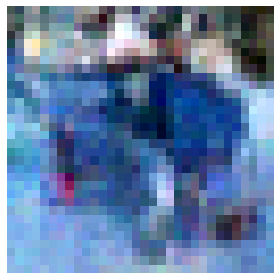

In [ ]:
main()

In [40]:
def smpl(
    # Model hyperparameters
    patch_size=4,
    hidden_size=64,
    mix_patch_size=512,
    mix_hidden_size=512,
    num_blocks=4,
    t1=10.0,
    # Optimisation hyperparameters
    num_steps=1_000_000,
    lr=3e-4,
    batch_size=256,
    print_every=10_000,
    # Sampling hyperparameters
    dt0=0.1,
    sample_size=8,
    # Seed
    seed=2023,
):
    key = jr.PRNGKey(seed)
    model_key, train_key, loader_key, sample_key = jr.split(key, 4)
    data = cifar()
    data_mean = jnp.mean(data)
    data_std = jnp.std(data)
    data_max = jnp.max(data)
    data_min = jnp.min(data)
    data_shape = data.shape[1:]
    data = (data - data_mean) / data_std

    model = Mixer2d(
        data_shape,
        patch_size,
        hidden_size,
        mix_patch_size,
        mix_hidden_size,
        num_blocks,
        t1,
        key=model_key,
    )
    int_beta = lambda t: t  # Try experimenting with other options here!
    weight = lambda t: 1 - jnp.exp(
        -int_beta(t)
    )  # Just chosen to upweight the region near t=0.


    model_loaded = eqx.tree_deserialise_leaves("/content/gdrive/MyDrive/Colab_Notebooks/cifar10_model.eqx", model)
   

    sample_key = jr.split(sample_key, sample_size**2)
    sample_fn = ft.partial(single_sample_fn, model_loaded, int_beta, data_shape, dt0, t1)
    sample = jax.vmap(sample_fn)(sample_key)
    sample = data_mean + data_std * sample
    sample = jnp.clip(sample, data_min, data_max)
    sample1 = sample[:, 0, :, :]
    sample2 = sample[:, 1, :, :]
    sample3 = sample[:, 2, :, :]
   
    sample1 = einops.rearrange(sample1, "(n1 n2) h w -> (n1 h) (n2 w) ", n1=sample_size, n2=sample_size)
    sample2 = einops.rearrange(sample2, "(n1 n2) h w -> (n1 h) (n2 w) ", n1=sample_size, n2=sample_size)
    sample3 = einops.rearrange(sample3, "(n1 n2) h w -> (n1 h) (n2 w) ", n1=sample_size, n2=sample_size)

    sample1 = sample1[None,:,:]
    sample2 = sample2[None,:,:]
    sample3 = sample3[None,:,:]
    
    newsamp = jnp.concatenate([sample1, sample2, sample3])
    print(newsamp.shape)
    sample = einops.rearrange(newsamp, "c h w -> h w c")
    sample = jnp.array(sample, dtype=int)
    
    # eqx.tree_serialise_leaves("cifar10_model.eqx", model)
    # shutil.copy('/content/cifar10_model.eqx','/content/gdrive/MyDrive/Colab_Notebooks')


    # sample = single_sample_fn( model, int_beta, data_shape, dt0, t1, sample_key)
    # sample = data_mean + data_std * sample
    # sample = jnp.clip(sample, data_min, data_max)
    # sample = einops.rearrange(sample, "c h w -> h w c") # tranpose
    # sample = jnp.array(sample, dtype=int)
    # print(sample)
    
    
    plt.imshow(sample)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

(3, 256, 256)


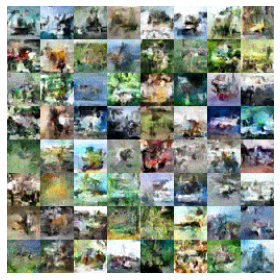

In [41]:
smpl()